In [1]:
location = '/home/pshah/Documents/code/'
import sys; sys.path.append('%sutils_praj' % location)
sys.path.append('%sNeuronalModelling/' % location)


# import funcs_pj as pj
import matplotlib.pyplot as plt
# import numpy as np
from brian2_recurrentnet_seizures import brian2_utils as b2utils

import pickle
import pandas as pd

from brian2 import *

In [7]:
#%% INITIALIZING THE MODEL
model_name = 'rec_sz1'
print('Welcome. This model is called ...', model_name)

#  experimenting with different synapse equations
#
# # difference of exponentials synapse
# x = np.linspace(0, 40, 500)
# y = (3 * (np.exp(-(x/2)) - np.exp(-(x/3))))
# plt.plot(x, y)
# plt.show()



# setup for network:
# Parameters
Cm = 0.25 * nfarad
gL = 16.7 * nsiemens

Ne = 800*5  # number of E neurons
Ni = 200*5 # number of I neurons
Nx = 800  # number of X (external population) neurons
Ntotal  = Ne+Ni

tau = 15 * ms
Vl = -75 * mV  # resting potential
V_t = -50 * mV  # threshold
V_refrac = -60 * mV  # refractory voltage

# Time constants
tau = 5 * ms
tau_d = 5 * ms
tau_g = 100*ms  # used for timescale of the inh. exhaust mechanism need to find better justification for the proper timescale of this for the actual simulation


# Reversal potentials
Ee = 0 * mV
V_rev_X = 0 * mV
Ei = -80 * mV
w_e = 2.4 * nsiemens  # excitatory synaptic weight
w_i = 40 * nsiemens  # inhibitory synaptic weight
w_x = 5.4 * nsiemens  # external input synaptic weight

gi_t = 200 * nsiemens # threshold value after which synaptic inh. strength starts to decrease
factor = 1 * nsiemens # factor needed for the model eqs for the exhaust inh part

runtime = 3*second
dt = 0.1*ms


# # EXTERNAL STIMULUS (I KNOW THAT THE ORDER OF THIS IS REALLY WEIRD BUT THIS SECTION AND THE MODEL EQS CANNOT BE ADDED TO THE NETWORK BUILD FUNCTION DEFINITION SINCE IT KICKS UP ERRORS IN BRIAN
stim_external = True
# define external stimulus as a TimedArray of time dependent values
stim_onset = 2.000 * second
stim_off =   2.150 * second
stim = np.empty([int(runtime / dt), Ntotal])
# stimulus = TimedArray(stim * amp, dt=0.1 * ms)  # constant current input into the specified  cells at the specified onset and offset times
if stim_external:
    neurons_to_stim = arange(200,300)
    stim[int(stim_onset / dt):int(stim_off / dt), neurons_to_stim] = 5
    stimulus = TimedArray(stim * amp,
                          dt=0.1 * ms)  # constant current input into the specified  cells at the specified onset and offset times

# The model
eqs = Equations('''
dV/dt = 1/Cm * (stimulus(t,i) + gL*(Vl - V) + ge*(Ee-V) + z * gi*(Ei-V)) : volt (unless refractory)
dge/dt = -ge/tau_d : siemens
dgi/dt = -gi/tau_d : siemens

# z factor used to capture changes in Inh. synaptic effectiveness
dz/dt = 1/tau_g * (z_inf - z) : 1
z_inf = 1/(1 + exp(-2*1.0*gi_diff)) : 1
gi_diff = (gi_t - gi)/factor : 1  # note that this is not addition because gi has +ve weight
''')

Welcome. This model is called ... rec_sz1


In [8]:
#%% NETWORK BUILD PART 2 - SETTING UP BRIAN STRUCTURE
def build_network(record_id, inh_conn=0.2, input_rate=2.5):

    start_scope()

    G = NeuronGroup(Ntotal, model=eqs, threshold='V > V_t', refractory=2*ms, reset= 'V = V_refrac',
                    method='euler', dt=0.1*ms)
    Ge = G[:Ne]
    Gi = G[Ne:Ntotal]

    # defining synapses and synaptic connections
    Ce = Synapses(G, G, on_pre='ge+=w_e')
    Ci = Synapses(G, G, on_pre='gi+=w_i')
    Ce.connect('i<4000', p=0.2)  # Excitatory connectivity
    Ci.connect('i>=4000', p=inh_conn)  # Inhibitory connectivity

    #
    # BACKGROUND Poisson input
    P = PoissonGroup(Nx, rates=input_rate*Hz, dt=0.1*ms)
    CX = Synapses(P, G, on_pre='ge+=w_x')
    CX.connect(p=0.2)  # Excitatory external drive connectivity

    # CeX = Synapses(P, Ge, on_pre='ge+=w_x')
    # CiX = Synapses(P, Gi, on_pre='ge+=w_x')
    # CeX.connect(p=0.2)
    # CiX.connect(p=0.2)


    # Initialization
    G.V = 'Vl + rand() * (V_t - Vl)'
    G.ge = 0
    G.gi = 0
    G.z = 1.

    # Setup a few monitors
    trace = StateMonitor(G, 'V', record=record_id)
    trace_ge = StateMonitor(G, 'ge', record=record_id)
    trace_gi = StateMonitor(G, 'gi', record=record_id)
    s_mon = SpikeMonitor(G)
    s_mon_p = SpikeMonitor(P)
    
    # these are for tracking the Inh. exhaust stuff
    trace_z = StateMonitor(G, 'z', record=record_id)
    trace_gi = StateMonitor(G, 'gi', record=record_id)
    trace_gi_diff = StateMonitor(G, 'gi_diff', record=record_id)

    net = Network(collect())

    return net, trace, s_mon, trace_ge, s_mon_p, Ce, Ci, Ge, Gi, G, trace_z, trace_gi, trace_gi_diff


def make_plots_inh_exhaust_mech(s_mon, s_mon_p, trace, trace_z, trace_gi_diff, trace_gi, trace_ge, neuron, xlimits):
    "bunch of plots for looking at the Inh. exhaust mech"
    
    plt.style.use('dark_background')
    
    figure(figsize=[20,3])
    plot(s_mon.t/ms, s_mon.i, ',k', color='white')
    xlabel('t (ms)')
    ylabel('Neuron index')
    show()
    spike_counts = s_mon.count
    spike_counts_Hz = array(spike_counts/runtime)
    avg=mean(spike_counts_Hz); print('average spiking rate of population: ', avg, 'Hz')
    
    
    figure(figsize=[20,3])
    plot(s_mon.t/ms, s_mon.i, ',k', color = 'white')
    if xlimits:
        xlim(xlimits)
    xlabel('t (ms)')
    ylabel('Neuron index - main group')
    show()
    
    figure(figsize=[20,3])
    plot(s_mon_p.t/ms, s_mon_p.i, ',k', color = 'white')
    if xlimits:
        xlim(xlimits)
    xlabel('t (ms)')
    ylabel('Neuron index - input group')
    show()
    
    
    b2utils.plot_voltage(voltage_monitor=trace, spike_monitor=s_mon, neuron_id=[neuron], alpha=0.7, ylimits=[-95, 20], xlimits=xlimits)
#     plt.figure(figsize=[20,3])
#     plot(trace.t/ms, trace[neuron].V/mV)
#     if xlimits:
#         xlim(xlimits)
#         ylim([-80, -40])
#     xlabel('t (ms)')
#     ylabel('mV')
#     show()


    plt.figure(figsize=[20,3])
    plot(trace_z.t/ms, trace_z[neuron].z)
    if xlimits:
        xlim(xlimits)
#         ylim([0.0, 1.0])
    xlabel('t (ms)')
    ylabel('z')
    show()

    plt.figure(figsize=[20,3])
    plot(trace_gi_diff.t/ms, trace_gi_diff[neuron].gi_diff)
    if xlimits:
        xlim(xlimits)
        ylim([-700, 700])
    xlabel('t (ms)')
    ylabel('gi_diff')
    show()

    plt.figure(figsize=[20,3])
    plot(trace_gi.t/ms, trace_gi[neuron].gi/nS)
    if xlimits:
        xlim(xlimits)
        ylim([0, 500])
    xlabel('t (ms)')
    ylabel('gi')
    show()
    
    plt.figure(figsize=[20,3])
    plot(trace_ge.t/ms, trace_ge[neuron].ge/nS)
    if xlimits:
        xlim(xlimits)
    xlabel('t (ms)')
    ylabel('ge')
    show()

WARNING    "dt" is an internal variable of group "poissongroup", but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Starting simulation at t=0. s for a duration of 5. s
1.2527 s (25%) simulated in 10s, estimated 30s remaining.
2.4494 s (48%) simulated in 20s, estimated 21s remaining.
3.6624 s (73%) simulated in 30s, estimated 11s remaining.
4.9021 s (98%) simulated in 40s, estimated 1s remaining.
5. s (100%) simulated in 40s


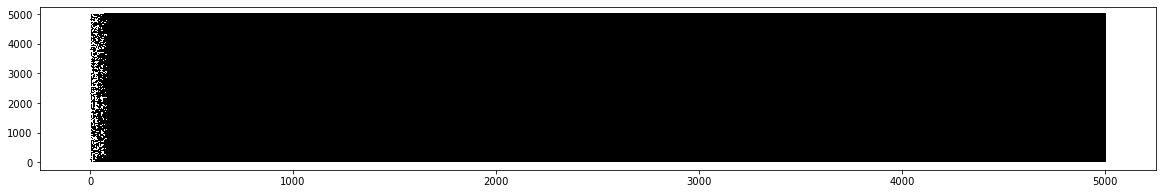

average spiking rate of population:  490.6552 Hz


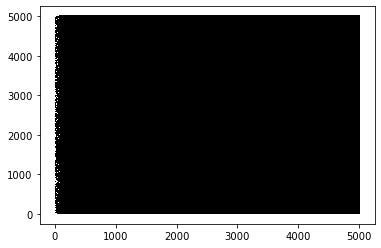

In [9]:
#%% BUILD AND RUN NETWORK
runtime = 5*second
dt = 0.1*ms

# build network
record_id=[100, 4000, 2300, 3049, 494, 209, 250, 1505]
net, trace, s_mon, trace_ge, s_mon_p, Ce, Ci, Ge, Gi, G, trace_z, trace_gi, trace_gi_diff = build_network(record_id=record_id, inh_conn=0.2)

# run simulation
net.run(runtime, report='text')

# quick spike raster plot to initialize plotting
figure(figsize=[20,3])
plot(s_mon.t/ms, s_mon.i, ',k'); plt.show()
spike_counts = s_mon.count
spike_counts_Hz = array(spike_counts/runtime)
avg=mean(spike_counts_Hz); print('average spiking rate of population: ', avg, 'Hz')

plt.plot(s_mon.t/ms, array(s_mon.i), ',k')
plt.show()